In [1]:
# Install Sentence-Transformers (only needed once)
# !pip install -q sentence-transformers

from google.colab import files
import pandas as pd
from sentence_transformers import SentenceTransformer

# Upload file
uploaded = files.upload()
csv_file = list(uploaded.keys())[0]

# Load CSV with fallback
try:
    df = pd.read_csv(csv_file)
except UnicodeDecodeError:
    print("[WARNING] UTF-8 decoding failed. Retrying with ISO-8859-1...")
    df = pd.read_csv(csv_file, encoding='ISO-8859-1')

# Preview
print("Sample rows from the uploaded file:")
print(df.head())

# Check required columns
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Your CSV must contain 'text' and 'label' columns!")

# 🔄 Convert labels: FAKE → 0, REAL → 1
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})
if df['label'].isnull().any():
    raise ValueError("Label column contains values other than 'FAKE' and 'REAL'.")

# Load Sentence-BERT
print("\n[INFO] Generating 384-dimensional embeddings using Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dim, fast

# Generate embeddings
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Create DataFrame with embeddings + labels
emb_df = pd.DataFrame(embeddings)
emb_df['label'] = df['label']

# Save output
output_filename = "merged_fake_news_dataset_new.csv"
emb_df.to_csv(output_filename, index=False)

# Download file
print(f"\n✅ File '{output_filename}' is ready for download.")
files.download(output_filename)


Saving fake_or_real_news.csv to fake_or_real_news.csv
Sample rows from the uploaded file:
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

[INFO] Generating 384-dimensional embeddings using Sentence-BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/198 [00:00<?, ?it/s]


✅ File 'merged_fake_news_dataset_new.csv' is ready for download.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1, Loss: 102.1153, Val Accuracy: 0.6496
Validation RMSE: 0.4698, R²: 0.1161
Epoch 2, Loss: 95.1873, Val Accuracy: 0.6117
Validation RMSE: 0.4822, R²: 0.0688
Epoch 3, Loss: 92.4836, Val Accuracy: 0.6803
Validation RMSE: 0.4516, R²: 0.1834
Epoch 4, Loss: 90.4904, Val Accuracy: 0.6803
Validation RMSE: 0.4532, R²: 0.1774
Epoch 5, Loss: 88.8225, Val Accuracy: 0.6527
Validation RMSE: 0.4614, R²: 0.1473
Epoch 6, Loss: 95.8682, Val Accuracy: 0.6598
Validation RMSE: 0.4568, R²: 0.1645
Epoch 7, Loss: 92.2498, Val Accuracy: 0.6803
Validation RMSE: 0.4498, R²: 0.1898
Epoch 8, Loss: 86.2291, Val Accuracy: 0.6780
Validation RMSE: 0.4502, R²: 0.1882
Epoch 9, Loss: 83.5608, Val Accuracy: 0.7088
Validation RMSE: 0.4359, R²: 0.2392
Epoch 10, Loss: 80.0967, Val Accuracy: 0.7017
Validation RMSE: 0.4402, R²: 0.2238
Epoch 11, Loss: 77.6323, Val Accuracy: 0.7111
Validation RMSE: 0.4332, R²: 0.2486
Epoch 12, Loss: 75.3750, Val Accuracy: 0.7159
Validation RMSE: 0.4330, R²: 0.2491
Epoch 13, Loss: 72.3494,

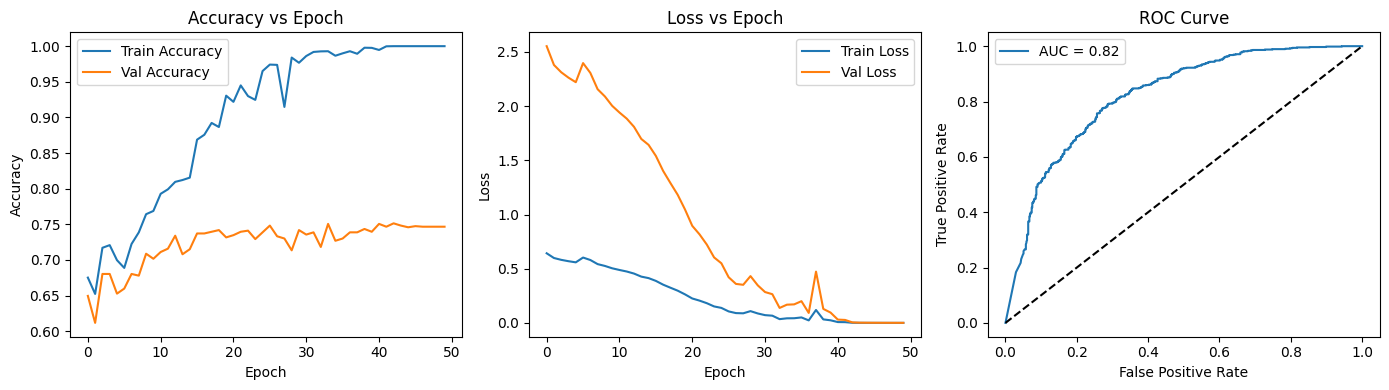

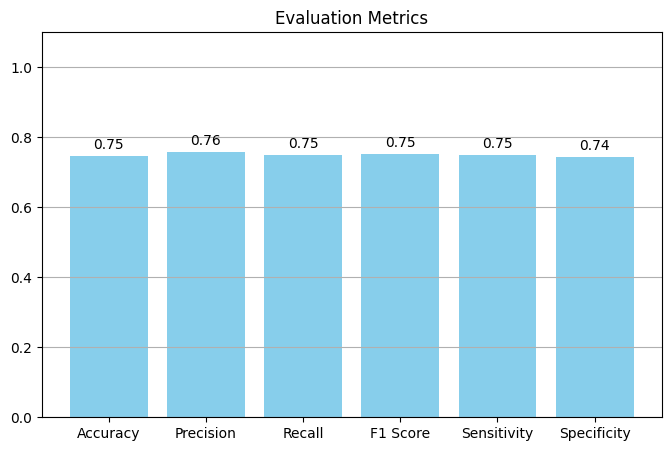

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# -------------------------------
# AWLSTM Cell
# -------------------------------
class AWLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AWLSTMCell, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.project = nn.Linear(input_size, hidden_size)

    def forward(self, x, hx=None):
        lstm_out, (hn, cn) = self.lstm(x, hx)
        x_trimmed = x[:, -lstm_out.size(1):, :]
        x_proj = self.project(x_trimmed.reshape(-1, x_trimmed.shape[2]))
        x_proj = x_proj.view(x.size(0), -1, lstm_out.size(2))
        output = self.alpha * lstm_out + (1 - self.alpha) * x_proj
        return output, (hn, cn)

# -------------------------------
# CNN + AWLSTM Model
# -------------------------------
class DeepfakeCNNRNN(nn.Module):
    def __init__(self, input_dim=384, cnn_channels=64, rnn_hidden_size=128):
        super(DeepfakeCNNRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.input_proj = nn.Linear(cnn_channels, rnn_hidden_size)
        self.rnn = AWLSTMCell(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)             # (batch, 1, 384)
        x = self.cnn(x)                # (batch, 64, 96)
        x = x.permute(0, 2, 1)         # (batch, 96, 64)
        x = self.input_proj(x)         # (batch, 96, 128)
        out, _ = self.rnn(x)           # (batch, 96, 128)
        return self.classifier(out[:, -1])  # (batch, 1)

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv("merged_fake_news_dataset_new.csv")
X = df.drop(columns=["label"]).values.astype(np.float32)
y = df["label"].values.astype(np.float32)
y = 1 - y  # optional flip

# Scale input
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Dataset and Dataloader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# -------------------------------
# Train Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeCNNRNN(input_dim=384).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Train accuracy
    model.eval()
    train_preds, train_targets = [], []
    with torch.no_grad():
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            train_preds.extend(preds.view(-1).round().cpu().numpy())
            train_targets.extend(yb.view(-1).cpu().numpy())

    train_acc = accuracy_score(train_targets, train_preds)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    val_probs, val_preds, val_targets = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_probs.extend(preds.view(-1).cpu().numpy())
            val_preds.extend(preds.view(-1).round().cpu().numpy())
            val_targets.extend(yb.view(-1).cpu().numpy())

    acc = accuracy_score(val_targets, val_preds)
    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(acc)
    rmse = np.sqrt(mean_squared_error(val_targets, val_probs))
    r2 = r2_score(val_targets, val_probs)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Accuracy: {acc:.4f}")
    print(f"Validation RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -------------------------------
# Save Model
# -------------------------------
torch.save(model.state_dict(), "deepfake_cnn_awlstmm.pth")

# -------------------------------
# Evaluation Metrics + Plotting
# -------------------------------
y_true = np.array(val_targets)
y_pred = np.array(val_preds)
probs = np.array(val_probs)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall  # same as recall

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# -------------------------------
# Plots
# -------------------------------

# Accuracy Plot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# ROC Curve
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation Metric Bar Plot
scores = [acc, precision, recall, f1, sensitivity, specificity]
labels = ["Accuracy", "Precision", "Recall", "F1 Score", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color='skyblue')
plt.title("Evaluation Metrics")
plt.ylim(0, 1.1)
plt.grid(axis='y')
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()
